# Summary

This notebook contains my trainng and prediction pipeline written in Tensorflow for the SIIM's Melanoma Competetion - 2020. Several EfficientNet models were trained with different parameters and the final model was an ensemble of several CNNs.

# Google Colab Initialization

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/SIIM-ISIC Melanoma Classification/Data/TripleStratified 512x512 Upsample/EfficientNetB7 512x512 Model Upsample"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/SIIM-ISIC Melanoma Classification/Data/TripleStratified 512x512 Upsample/EfficientNetB7 512x512 Model Upsample

/content/gdrive/My Drive/Kaggle/SIIM-ISIC Melanoma Classification/Data/TripleStratified 512x512 Upsample/EfficientNetB7 512x512 Model Upsample


# Initialize Environment

In [ ]:
!pip install -q efficientnet >> /dev/null

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import PIL

## Configuration

* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [ ]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [512,512,512,512,512]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]

# Malignant images
M_NEW = [1,1,1,1,1]
M_2020 = [1,1,1,1,1]
M_2018 = [1,1,1,1,1]
# MALIGNANT2019 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [8]*FOLDS
EPOCHS = [12]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [7,7,7,7,7]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 15

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.69.19.98:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [ ]:
# 2020 Comp Data 512x512: gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b
# 2019+2018+2017 Comp Data 512x512: gs://kds-823a9066a531d4a2cb81f281a88a2235b28df4699c8eaf2a0b1f5208
# Malignant Image Data 512x512: gs://kds-0d477718418961fee4483712e6a7f1ce526d038c6ef905940ee637b8

GCS_PATH = [None]*FOLDS
GCS_PATH2 = [None]*FOLDS
GCS_PATH3 = [None]*FOLDS

for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i]  = 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b'     # Current comp data
    GCS_PATH2[i] = 'gs://kds-823a9066a531d4a2cb81f281a88a2235b28df4699c8eaf2a0b1f5208'     # Previous comp data
    GCS_PATH3[i] = 'gs://kds-0d477718418961fee4483712e6a7f1ce526d038c6ef905940ee637b8'     # Malignant Images for upsampling

files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))
files_mailg = np.sort(np.array(tf.io.gfile.glob(GCS_PATH3[0] + '/train*.tfrec')))

# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [ ]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=512):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=512):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [ ]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=512):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

## Test Augmentation Pipeline


### Train Images

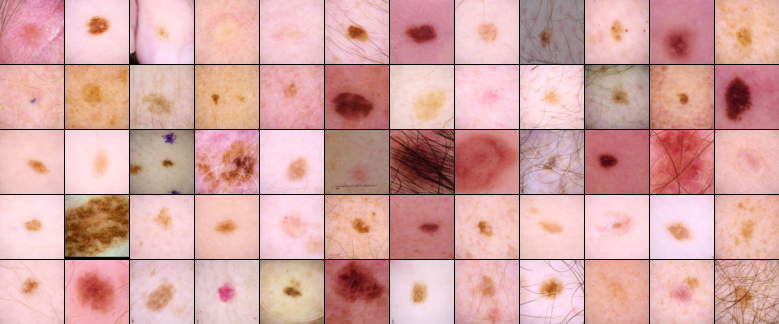

In [ ]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        data, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(data.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)


### Test Augmentations

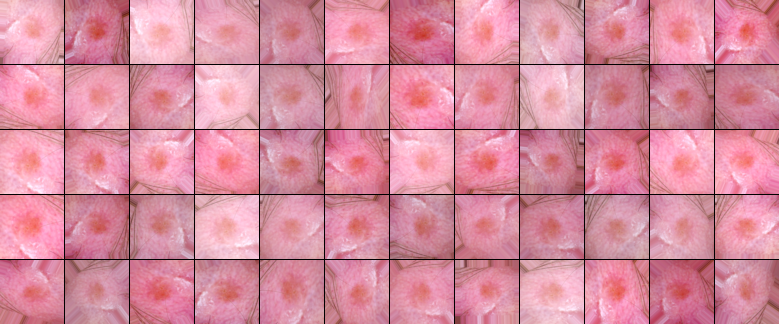

In [ ]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda data, target: (prepare_image(data, augment=True, dim = 512), target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

### Test Images

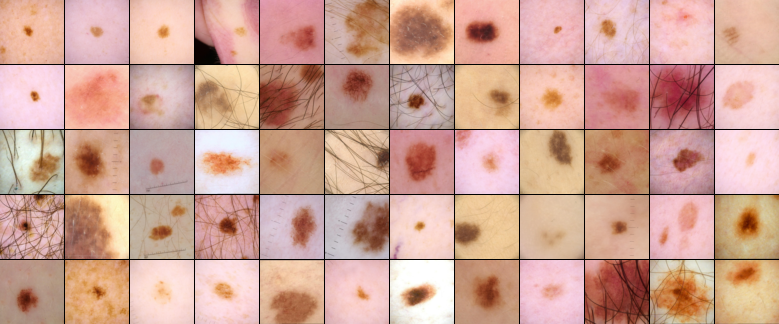

In [ ]:
ds = get_dataset(files_test, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

### Malignant Images 

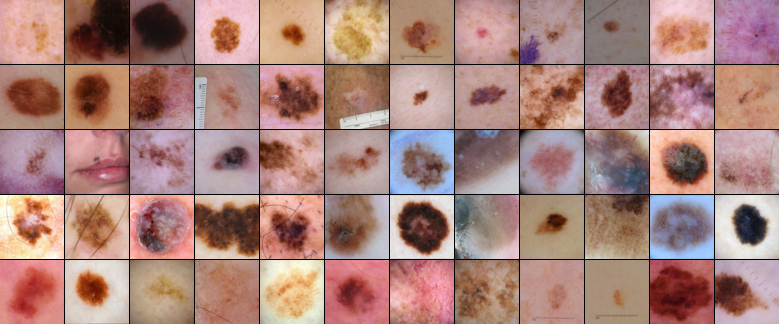

In [ ]:
ds = get_dataset(files_mailg).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(dim=384, ef=4):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc', factor = 0.7, patience = 3,
                                                               verbose = 1, min_lr = 1e-7, mode = 'max')

def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

### 1. Using New Upsampled Malignant Data

INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 1
#### Image Size 512 with EfficientNet B7 and batch_size 64
#### Using 2018+2017 external data
#### Using Never Seen Before Malignant Data
#### Upsampling 2020 Malignant Data
#### Upsampling 2018 Malignant Data
#########################
Training...
Epoch 1/12
443/443 [==============================] - ETA: 0s - auc: 0.8965 - loss: 0.2712
Epoch 00001: val_auc improved from -inf to 0.86498, saving model to b7_512_up_fold-0.h5
443/443 [==============================] - 436s 985ms/step - auc: 0.8965 - loss: 0.2712 - val_auc: 0.8650 - val_loss: 0.1817 - lr: 1.0000e-04
Epoch 2/12
443/443 [==============================] - ETA: 0s - auc: 0.9354 - loss: 0.2303
Epoch 00002: val_auc improved from 0.86498 to 0.88030, saving model to b7_512_up_fold-0.h5
443/443 [==============================] - 405s 914ms/step - auc: 0.9354 - loss: 0.2303 - val_auc: 0.8803 - val_loss: 0.1863 - lr: 1.0000e-04
Epoch 3/12
443/443 [==============================] - ETA: 0s - auc: 

INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Loading best model...
Predicting OOF with TTA...
383/382 [==============================] - 235s 614ms/step
Predicting Test with TTA...
644/643 [==============================] - 402s 625ms/step
#### FOLD 1 OOF AUC without TTA = 0.909, with TTA = 0.929


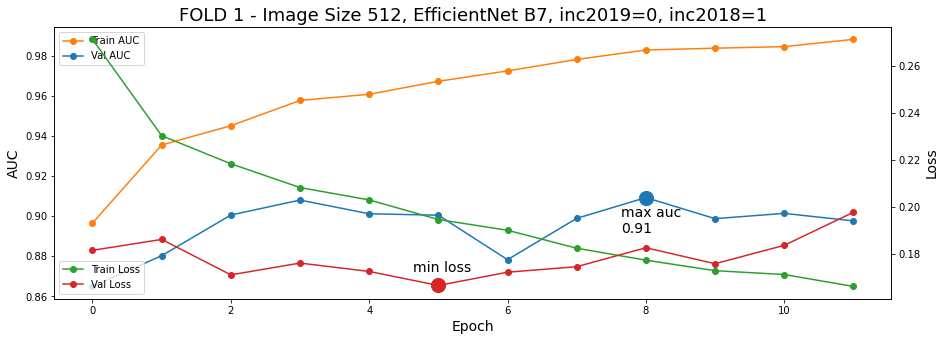

INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 2
#### Image Size 512 with EfficientNet B7 and batch_size 64
#### Using 2018+2017 external data
#### Using Never Seen Before Malignant Data
#### Upsampling 2020 Malignant Data
#### Upsampling 2018 Malignant Data
#########################
Training...
Epoch 1/12
443/443 [==============================] - ETA: 0s - auc: 0.9062 - loss: 0.2753
Epoch 00001: val_auc improved from -inf to 0.85934, saving model to b7_512_up_fold-1.h5
443/443 [==============================] - 433s 977ms/step - auc: 0.9062 - loss: 0.2753 - val_auc: 0.8593 - val_loss: 0.1910 - lr: 1.0000e-04
Epoch 2/12
443/443 [==============================] - ETA: 0s - auc: 0.9355 - loss: 0.2282
Epoch 00002: val_auc did not improve from 0.85934
443/443 [==============================] - 395s 891ms/step - auc: 0.9355 - loss: 0.2282 - val_auc: 0.8580 - val_loss: 0.2024 - lr: 1.0000e-04
Epoch 3/12
443/443 [==============================] - ETA: 0s - auc: 0.9442 - loss: 0.2191
Epoch 00003: val_au

INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Loading best model...
Predicting OOF with TTA...
383/382 [==============================] - 234s 612ms/step
Predicting Test with TTA...
644/643 [==============================] - 400s 621ms/step
#### FOLD 2 OOF AUC without TTA = 0.885, with TTA = 0.893


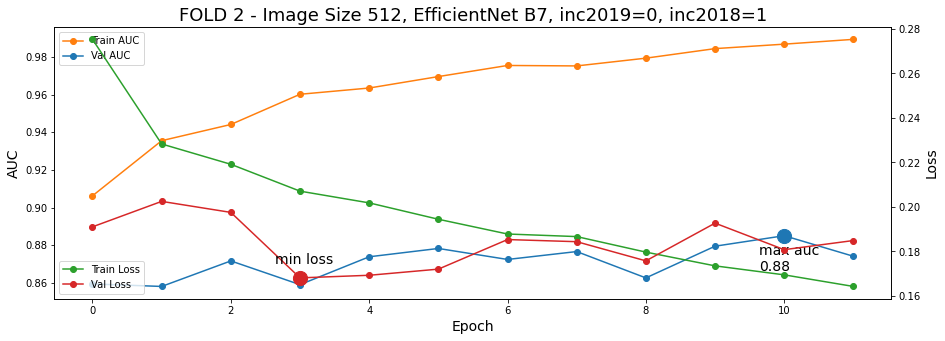

INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.19.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 3
#### Image Size 512 with EfficientNet B7 and batch_size 64
#### Using 2018+2017 external data
#### Using Never Seen Before Malignant Data
#### Upsampling 2020 Malignant Data
#### Upsampling 2018 Malignant Data
#########################
Training...
Epoch 1/12
443/443 [==============================] - ETA: 0s - auc: 0.8995 - loss: 0.2727
Epoch 00001: val_auc improved from -inf to 0.86095, saving model to b7_512_up_fold-2.h5
443/443 [==============================] - 435s 982ms/step - auc: 0.8995 - loss: 0.2727 - val_auc: 0.8610 - val_loss: 0.1735 - lr: 1.0000e-04
Epoch 2/12
443/443 [==============================] - ETA: 0s - auc: 0.9320 - loss: 0.2328
Epoch 00002: val_auc improved from 0.86095 to 0.89998, saving model to b7_512_up_fold-2.h5
443/443 [==============================] - 406s 916ms/step - auc: 0.9320 - loss: 0.2328 - val_auc: 0.9000 - val_loss: 0.1653 - lr: 1.0000e-04
Epoch 3/12
443/443 [==============================] - ETA: 0s - auc: 

In [ ]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # if fold == 0:
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    if M_NEW[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Using Never Seen Before Malignant Data')
    if M_2020[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsampling 2020 Malignant Data')
    if M_2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsampling 2018 Malignant Data')

    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'b7_512_up_fold-%i.h5'%fold, monitor='val_auc', verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
  
    # TRAIN
    print('Training...')
    history = model.fit(
                        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                                    dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
                        epochs = EPOCHS[fold],
                        callbacks = [sv,learning_rate_reduction], 
                        steps_per_epoch = count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                        validation_data = get_dataset(files_valid,augment=False,shuffle=False,
                                                      repeat=False,dim=IMG_SIZES[fold]), #class_weight = {0:1,1:2},
                        verbose=VERBOSE
                        )
    
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
        
    print('Loading best model...')
    model.load_weights('b7_512_up_fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                          repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid)
    STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                          labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test)
    STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        # plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=0, inc2018=0'%
        #          (fold+1,IMG_SIZES[fold],EFF_NETS[fold]),size=18)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()  

## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [ ]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('b6_512_up_oof.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.925


,image_name,target,pred,fold
0,ISIC_2637011,0,0.025055,0
1,ISIC_0076262,0,0.026306,0
2,ISIC_0074268,0,0.028109,0
3,ISIC_0015719,0,0.032388,0
4,ISIC_0082543,0,0.032812,0


# Submit To Kaggle

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('b6_512_up_submission.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.037216
1443,ISIC_0052349,0.023110
3120,ISIC_0058510,0.024978
4870,ISIC_0073313,0.022655
5494,ISIC_0073502,0.048909


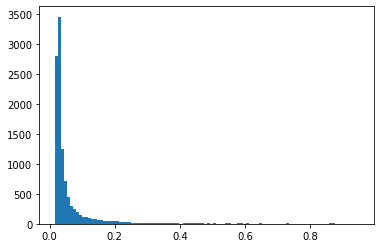

In [ ]:
plt.hist(submission.target,bins=100)
plt.show()